## Assignment 3

* The purpose of this assignment is to compute the sentiment of text information - in our case, tweets posted recently on Canadian Elections. The goal is to essentially use sentiment analysis on Twitter data to get insight into the Canadian Elections
* Research question:  “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” 
* When writing the report, make sure to explain (for each step) what it is doing, why it is important, and the pros and cons of that approach.


## Import & Install Packages

In [ ]:
pip install bs4

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
pip install wordcloud

In [ ]:
pip install tensorflow

In [ ]:
pip install Keras

In [ ]:
pip install xgboost

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import html
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import operator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from itertools import product
from sklearn.preprocessing import MinMaxScaler

# model implementation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

## Import Data

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# sentiment_path = "/content/drive/My Drive/MASc First Year/MIE1624/a3/sentiment_analysis.csv"
# elections_path = "/content/drive/My Drive/MASc First Year/MIE1624/a3/Canadian_elections_2019.csv"

Mounted at /content/drive


In [5]:
# sentiment = pd.read_csv(sentiment_path)
# elections = pd.read_csv(elections_path)

In [ ]:
# import data
sentiment = pd.read_csv('sentiment_analysis.csv')
elections = pd.read_csv('Canadian_elections_2019.csv')

## Data Cleaning

The tweets, as given, are not in a form amenable to analysis –-- there is too much ‘noise’. Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter data for analysis by satisfying the requirements below.
* All html tags and attributes (i.e., /<[^>]+>/) are removed.
* Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
* All URLs are removed.
* All characters in the text are in lowercase.
* All stop words are removed. Be clear in what you consider as a stop word.
* If a tweet is empty after pre-processing, it should be preserved as such.

In [6]:
def clean_html(text):
    """
    Using beautifulSoup lxml to clean all html tags and attributes 
    """
    cleantext = BeautifulSoup(text,'lxml').text
    return cleantext

In [7]:
def remove_urls(text):
    """
    Using re.sub to remove urls 
    """
    cleantext = re.sub('(http|https|ftp)://[a-zA-Z0-9\\./]+', '', text) 
    return cleantext

In [8]:
def remove_newline(text):
    """
    Using repalce to remove all the newline notations \\n
    """
    return text.replace('\\n',' ')

In the Canadian Elections Data, there are quite a lot text that has newlines, If we don't remove those \\n in the text, n will concatenate with other words which would impact the process of removining stop words and lemmatization. 

In [9]:
# REFERENCE : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    """
    Remove emoji
    """
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
def remove_hashtag(text):
    """
    Using re.sub to remove hashtag 
    """
    return re.sub('@[^\s]+','', text)

Many tweets have those hashtag @ with someone's twitter usernames. Removing those hashtag with the names followed behind can reduce noise in the text.

In [11]:
stops = set(stopwords.words("english"))
stops.add("u")
stops.add("i")
stops.add("rt")
stops.add("b")

def remove_stopwords(text):
    """
    Remove words from the stopwords 
    """
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token for token in tokens if token not in stops]
    return ' '.join(tokens)

nltk's stopwords package is used for removing stop words. Words like "u", simplified version of "you" and lower case 'i' are not automatically removed by the stopwords. So "u" and  "i" are manually appended to the set. There are "rt" and "b" in the text, which can be removed to reduce noise.

In [12]:
wn = WordNetLemmatizer()

def lemmatizer(text):
    """
    Lemmatize word 
    """
    text = [wn.lemmatize(word) for word in text.split(' ')]
    return ' '.join(text)

Lemmatization is used on the words rather than stemming. Since stemming cuts too much on the word which only leaves the root of the word. Lemmatization transforming the word into the base or dictionary form would be an appropriate way to include some noise but still keeping the word in a complete form.

In [13]:
def data_cleaning(df):
    
    # create a new column called clean_text and convert text into string
    df['clean_text'] = df['text'].astype(str)
    
    # clean html tags and attributes
    df['clean_text'] = df['clean_text'].apply(clean_html) #
    
    # Unicode into ASCII equivalent
    df['clean_text'] = df['clean_text'].fillna("").apply(html.unescape)
    
    # remove urls
    df['clean_text'] = df['clean_text'].apply(remove_urls)
    
    # remove newline
    df['clean_text'] = df['clean_text'].apply(remove_newline)
    
    # remove emoji
    df['clean_text'] = df['clean_text'].apply(remove_emoji)
    
    # convert into lower case
    df['clean_text'] = df['clean_text'].str.lower()
    
    # remove hashtag
    df['clean_text'] = df['clean_text'].apply(remove_hashtag)
    
    # remove numbers, punctuations and special characters
    df['clean_text'] = df['clean_text'].str.replace('[^a-zA-Z]',' ')
    
    # remove stopwords
    df['clean_text'] = df['clean_text'].apply(remove_stopwords)
    
    # lemmatize words
    df['clean_text'] = df['clean_text'].apply(lemmatizer)
    
    return df

In [14]:
sentiment_df = data_cleaning(sentiment) # around 3 mins

In [ ]:
sentiment_df.head()

,ID,text,label,clean_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeder crown...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,congratulation pakistan becoming testteam worl...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,september taking maine mendoza surprise thanks...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,newly painted wall thanks million custodial pa...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,excited announce july feschotte lab relocating...


In [ ]:
elections_df = data_cleaning(elections)

In [ ]:
elections_df.head()

,sentiment,negative_reason,text,clean_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",instead suggestion agree canadian woman trust ...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real etobicokenorth cityofto...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next year ask jus...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection canadavotes elxn decide ...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayer sick tired hard earned donated...


## Exploratory Analysis

Design a simple procedure that determines the political party (Liberal, Conservatives or New Democratic Party (NDC)) of a given tweet and apply this procedure to all the tweets in the Canadian Elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties or candidates. What can you say about the distribution of the political affiliations of the tweets?



In [ ]:
def political_party(text):
    '''
    Assigning the tweets to the specific political parties based on keywords in the text. 
    '''
    # key words from each party
    lib_w = ['justintrudeau', 'justin', 'trudeau', 'pmtrudeau', 
             'libéral', 'liberal', 'liberals', 'libs', 'lib', 'liberalparty', 'lpc', 'ptlib', 
             'red','left', 'realchange', 'teamtrudeau', 'pm', 'primeminister', 'chooseforward']
    
    con_w = ['andrewscheer', 'andrew', 'scheer', 'harper',
             'conservative', 'conservatives', 'conservativeparty','cpc', 'pcc', 'pc', 'pcers', 'cpchq',
             'pctory', 'tory', 'tories', 'blue', 'right']
    
    ndp_w = ['jagmeetsingh', 'jagmeet','singh', 'tommulcair', 'mulcair',
             'ndp', 'ndp_hq', 'ptndp', 'ndp2019',  
              'orange', 'ready4change', 'farleft', 'newleft','new', 'democratic']
    
    min_w = ['maximebernier','maxime','bernier', 'elizabeth', 'elizabethmay',
             'greenparty','canadiangreens', 'green', 'ppc', ]
    
    # build a dictionary to count the frequency of the keywords appearing in the text
    party = {'Liberal':0,'Conservative':0,'NDP':0, 'Other':0} 

    # Search through the tweet for all of the words associated with the parties
    for w in lib_w:   
        if w in text:
            party['Liberal'] += 1
    
    for w in con_w:
        if w in text:
            party['Conservative'] += 1
            
    for w in ndp_w:
        if w in text:
            party['NDP'] += 1
    
    for w in min_w:
        if w in text:
            party['Other'] += 1
    
    # check if this text contains no keywords or same frequency of keywords across four parties
    expected_value = next(iter(party.values()))
    all_equal = all(value == expected_value for value in party.values())
    assign = 'Other'
    
    # if all frequency is the same, then this text is assigned to Other
    if all_equal == True:
        return assign
    # else assigns to the party has maximum number of keywords
    else:
        return max(party.items(), key = operator.itemgetter(1))[0]

The approach to determine political parties is checking whether the input text has any keywords listed above according to the four parties. Then we count keywords of each party. If the number of keywords are the same across four parties or no keywords exist, then it is hard to determine which party it is, then we assign it to "Other". Otherwise, the party having the maximum number of keywords is the party we assign to this tweet.

In [ ]:
elections_df['party'] = elections_df['clean_text'].apply(political_party)

In [ ]:
elections_df.head(10)

,sentiment,negative_reason,text,clean_text,party
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",instead suggestion agree canadian woman trust ...,Conservative
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real etobicokenorth cityofto...,Other
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next year ask jus...,Liberal
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection canadavotes elxn decide ...,Other
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayer sick tired hard earned donated...,Liberal
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",canadavotes elxn cdnpoli fact blastfromthepast...,Conservative
6,positive,NaN,"b""#CDNmedia #elxn43 #cdnpoli #PPC Rocky Dong h...",cdnmedia elxn cdnpoli ppc rocky dong hand best...,Conservative
7,positive,NaN,"b""#cdnpoli #elxn43 The Liberals ++ more than d...",cdnpoli elxn liberal double promised national ...,Liberal
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",chooseforward cdnpoli elxn canada make america...,Liberal
9,negative,Scandal,"b""#CPCKinsellaGate\nLet's see the receipts. Wh...",cpckinsellagate let see receipt pay warren kin...,Liberal


In [ ]:
elections_df['party'].value_counts()

Other           792
Liberal         660
Conservative    518
NDP             163
Name: party, dtype: int64

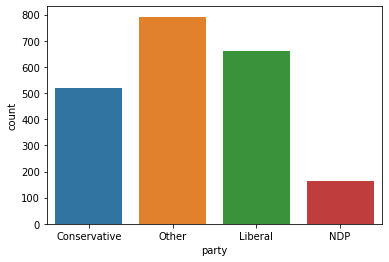

In [ ]:
sns.countplot(x = 'party', data = elections_df)

Based on our procedure determining the political parties, there are still many people are grouped into "Other" due to limited number of keywords found and simple function. Most people are grouped in to Liberal, Conservative in the second and NDP lastly. Liberal Party won the elections in 2019, so this procedure is reasonbale. Since the winning party should have received more attention no matter positive or negative compared to other parties. 

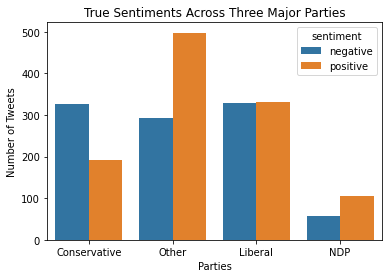

In [ ]:
ax = sns.countplot(x = "party", hue="sentiment", data= elections_df)
ax.set_title('True Sentiments Across Three Major Parties')
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Parties')

class_order = ['Liberal', 'Conservative', 'NDP', 'Other'] 
hue_order = [0, 1]
bar_order = product(class_order, hue_order)

The figure above reveals the true sentiment labels for each party. Liberal party has almost equal number of positive and negative sentiment tweets, whereas Conservative party has more negative sentiment tweets. NDP and Other have more positive sentiment tweets.


Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc.) that visualizes some aspect of the generic tweets in sentiment_analysis.csv and another figure for the 2019 Canadian Elections tweets. All graphs and plots should be readable and have all axes that are appropriately labelled.

(-0.5, 399.5, 199.5, -0.5)

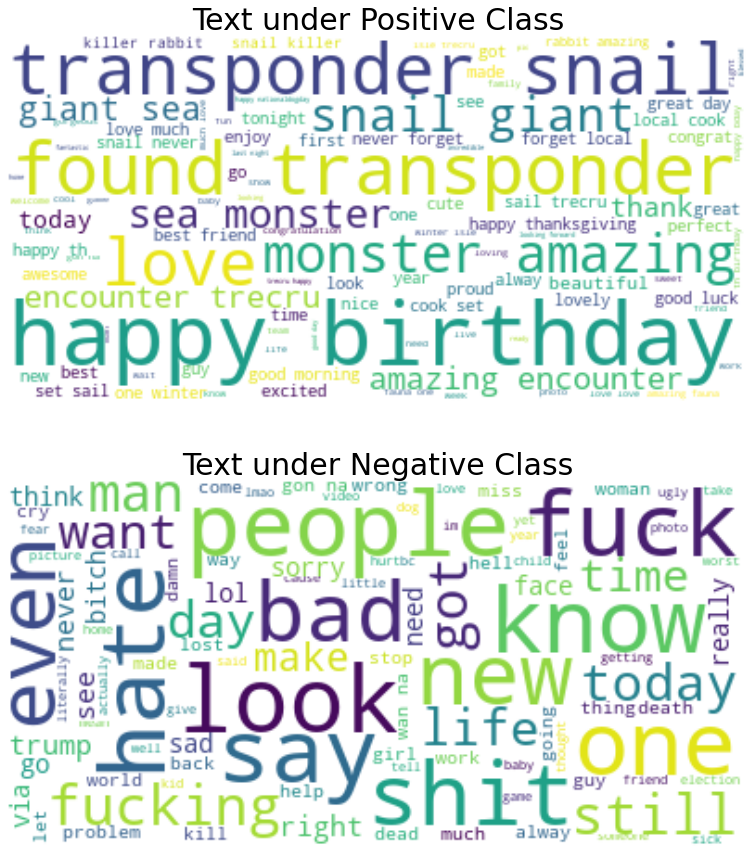

In [ ]:
sentiment_P = sentiment_df[sentiment_df['label'] == 1]
sentiment_N = sentiment_df[sentiment_df['label'] == 0]
text_P = " ".join(review for review in sentiment_P.clean_text)
text_N = " ".join(review for review in sentiment_N.clean_text)

fig, ax = plt.subplots(2, 1, figsize  = (15,15))

# Create and generate a word cloud image:
wordcloud_P = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_P)
wordcloud_N = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_N)

# Display the generated image:
ax[0].imshow(wordcloud_P, interpolation = 'bilinear')
ax[0].set_title('Text under Positive Class', fontsize = 30)
ax[0].axis('off')

ax[1].imshow(wordcloud_N, interpolation = 'bilinear')
ax[1].set_title('Text under Negative Class', fontsize = 30)
ax[1].axis('off')

Data cleaning on Twitter sentiment data seems to be quite successful. The two word clouds present the most frequent words appeared on both positive and negative sentiment classes. The positive sentiment class has words happy, love, amazing etc. The most frequent words in negative sentiment class are all swear words, which are reasonable.

Text(0, 0.5, 'Number of Tweets')

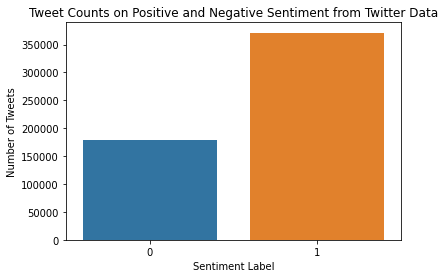

In [ ]:
sns.countplot(x = 'label', data = sentiment_df)
plt.title('Tweet Counts on Positive and Negative Sentiment from Twitter Data', fontsize=12)
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')

The sample size is very large. There are about 350,000 positive sentiment tweets. The Twitter sentiment data has much more positive tweets compared to negative tweets. When model being trained on this set of data, predictions will be made more likely as positive. The false positive rate might be higher. 

Text(0, 0.5, 'Number of Tweets')

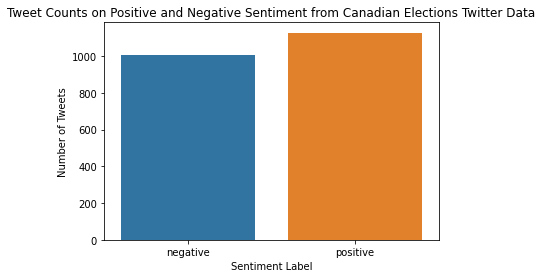

In [ ]:
sns.countplot(x = 'sentiment', data = elections_df)
plt.title('Tweet Counts on Positive and Negative Sentiment from Canadian Elections Twitter Data', fontsize=12)
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')

The Canadian Elections data has quite balanced sentiment label, but the sample size is relatively smaller than the Twitter sentiment data.

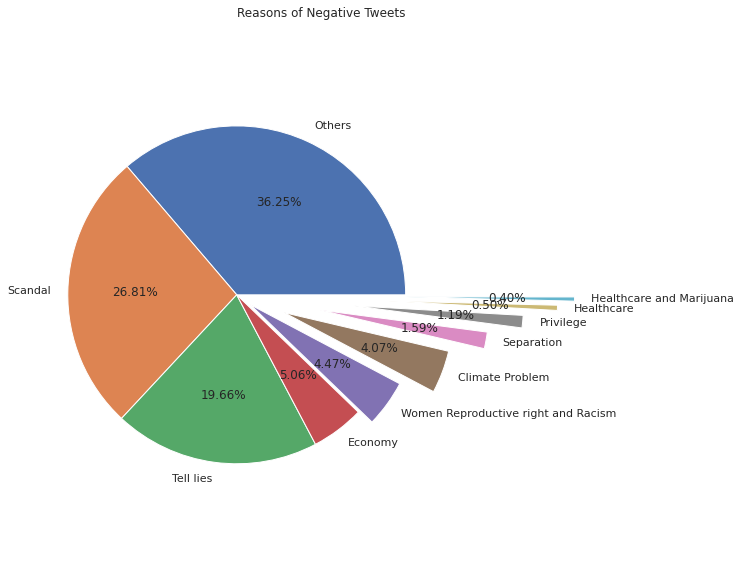

In [ ]:
elections_df.negative_reason.unique()

labels = list(elections_df['negative_reason'].value_counts().keys())
sizes = list(elections_df['negative_reason'].value_counts().values)
explode = (0, 0, 0, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1) 

fig, ax = plt.subplots()
ax.pie(sizes, explode, labels=labels, autopct='%1.2f%%', shadow=False)
ax.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Reasons of Negative Tweets', fontsize=12)
plt.show()

Looking at the decompositon of negative reasons, "others" occupies for 36.25% of the negative sentiment Canadian Elections data. The second largest number of negative reasons are "scandal", follwed by "tell lies". Negative reasons on healthcare occupies the least in the negative tweets.

Text(0, 0.5, 'Number of Negative Sentiment Tweets')

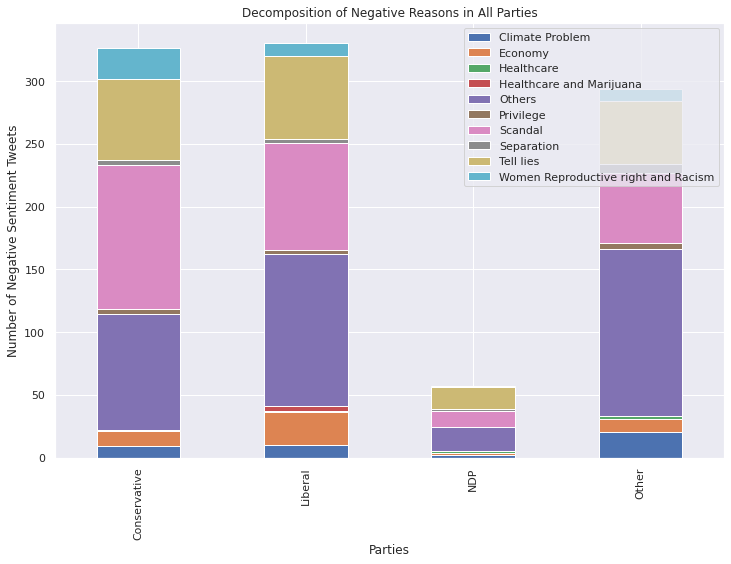

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})

plot_df = elections_df.groupby(['negative_reason', 'party']).size().reset_index().pivot(columns='negative_reason', 
                                                                                        index='party', values=0)
plot_df.plot(kind='bar', stacked=True)
plt.legend(loc='upper right')
plt.title('Decomposition of Negative Reasons in All Parties', fontsize=12)
plt.xlabel('Parties')
plt.ylabel('Number of Negative Sentiment Tweets')

The previous pie chart does not show the distributions of negative reasons on the four parties. This bar plot further shows which parties have greater number of which kind of negative reasons in Canadian Elections data. The Conservative party has the greatest number of scandal as the negative reason. Liberal party has economy as the most frequent negative reason. Other parties having the climate problem is reasonable, since the Green party in Others focuses more on the environmental problems.

## Model Preparation

Split the generic tweets randomly into training data (70%) and test data (30%).
Prepare the data to try seven classification algorithms -- logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost, where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, Bag of Words (word frequency) and TF-IDF on all 7 models. (Hint: Be careful about when to split the dataset into training and testing set.)

In [15]:
sentiment_df1 = sentiment_df.copy()

In [16]:
X = sentiment_df1['clean_text']
y = sentiment_df1['label']

# split data into 70% train and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [17]:
# bag of words
wf_vector = CountVectorizer(max_features = 1000)

X_train_wf = wf_vector.fit_transform(X_train).toarray()
X_test_wf = wf_vector.transform(X_test).toarray()
y_train_wf = y_train
y_test_wf = y_test

wf_traindf = pd.DataFrame(X_train_wf, columns = wf_vector.get_feature_names())
wf_testdf = pd.DataFrame(X_test_wf, columns = wf_vector.get_feature_names())

# pd.set_option('display.max_columns', 20)
wf_traindf.head()

,able,absolutely,abuse,account,act,action,actually,ad,add,adorable,adventure,advice,af,african,afternoon,ago,ahead,air,album,aldub,alive,almost,alone,already,also,always,amazing,amazon,america,american,anal,angel,angry,animal,anniversary,annoying,another,answer,anti,anymore,...,went,west,white,whole,wife,win,wine,winner,winning,winter,wish,wishing,without,woman,wonderful,word,work,working,workout,world,worry,worse,worst,worth,would,wow,writing,wrong,wtf,xx,ya,yay,yeah,year,yes,yesterday,yet,yo,young,yr
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Bag of words/word frequency simply calculates how many times the word appears in the clean text per tweet. 1000 words are chosen for the bag of words in order to capture as much meaningful information as we can.

In [18]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train_wf)
X_train_wf = scaler.transform(X_train_wf)
X_test_wf = scaler.transform(X_test_wf)

Since word frequency is simply the count of the word frequencies per tweet. It is necessary to normalize into the range between 0 and 1 for later models which needs scaled data and future hyperparameter tuning when l1 and l2 regularization is involved.

In [19]:
# TF-IDF
tfidf_vect = TfidfVectorizer(max_features = 1000) # max_features=72
X_train_tfidf = tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vect.transform(X_test).toarray()
y_train_tfidf = y_train
y_test_tfidf = y_test

tfidf_traindf = pd.DataFrame(X_train_tfidf, columns=tfidf_vect.get_feature_names())
tfidf_testdf = pd.DataFrame(X_test_tfidf, columns=tfidf_vect.get_feature_names())

# pd.set_option('display.max_columns', 20)
tfidf_traindf.head()

,able,absolutely,abuse,account,act,action,actually,ad,add,adorable,adventure,advice,af,african,afternoon,ago,ahead,air,album,aldub,alive,almost,alone,already,also,always,amazing,amazon,america,american,anal,angel,angry,animal,anniversary,annoying,another,answer,anti,anymore,...,went,west,white,whole,wife,win,wine,winner,winning,winter,wish,wishing,without,woman,wonderful,word,work,working,workout,world,worry,worse,worst,worth,would,wow,writing,wrong,wtf,xx,ya,yay,yeah,year,yes,yesterday,yet,yo,young,yr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.377273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TF-IDF is another metric to determine the importance of the word within a document, which calculates the product of the term frequency and inverse document frequency. 

We need to split the data into train and test before applying TF-IDF. Although splitting does not affect word frequency, it affects values in TF-IDF. After we split the data, TF-IDF's inverse document frequency is calculated within training and test data separately. If we calculate TD-IDF first, then split the data, the TF-IDF values will be meaningless because the model is only trained on training data with a wrong inverse document frequency.

1000 words are chosen to capture as much meaningful information as we can.


In [ ]:
# PCA
pca = PCA(n_components=20)
pca.fit(X_train_wf)
X_train_wf = pca.transform(X_train_wf)
X_test_wf = pca.transform(X_test_wf)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.14646184 0.03931677 0.01918627 0.01189538 0.00934832 0.00675343
 0.0062517  0.00519035 0.00500496 0.00481842 0.00468467 0.00453088
 0.00438915 0.00417078 0.00394784 0.00391137 0.00382009 0.00367679
 0.00363149 0.00356853]
[203.38040059 105.37455562  73.61090926  57.96102676  51.38230187
  43.67260154  42.019033    38.28645538  37.59647696  36.88919995
  36.3736142   35.77157523  35.20765004  34.32064325  33.39076891
  33.23620654  32.84610574  32.22411415  32.02502606  31.74619343]


In [ ]:
pca2 = PCA(n_components=20)
pca2.fit(X_train_tfidf)
X_train_tfidf = pca2.transform(X_train_tfidf)
X_test_tfidf = pca2.transform(X_test_tfidf)

print(pca2.explained_variance_ratio_)
print(pca2.singular_values_)

[0.02144273 0.01944033 0.01822108 0.00877498 0.00839784 0.00825905
 0.00792611 0.00740586 0.00667094 0.00557956 0.00546076 0.00516189
 0.00507802 0.00480475 0.00477964 0.00462673 0.00457131 0.00449436
 0.00434306 0.00426063]
[89.59206722 85.30633282 82.58793431 57.31291939 56.06776824 55.60252313
 54.47026676 52.65229794 49.9715666  45.70140833 45.21226011 43.95760938
 43.5990335  42.40967494 42.29868964 41.61661963 41.36659592 41.01694122
 40.3206293  39.93614727]


PCA is applied on both normalized word frequency and TF-IDF. Reasons are explained below:
1. Using 1000 words to train different models would require intensive computation, which is also inefficient. 
2. PCA is used for dimensionality reduction to project 1000 words onto only the first 20 principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible.
3. Using PCA can capture a better feature representation out of the 1000 words.
4. Using PCA can obtain the most important variance explained from the data.

After trial and error, we decide to use 20 componenets. With 50 to 70 components, the running time did not improve dramatically from using 70 feature directly from word frequency and TF-IDF. The model accuracies did not have a large difference between 20, 25, 30 and 40 principal components. Therefore, 20 is determined for the number of principal components to have faster running time while achieving good model accuracies.

## Model Implementation

Train models on the training data from generic tweets and apply the model to the
test data to obtain an accuracy value. Evaluate the same trained model with best
performance on the Canadian Elections data. How well do your predictions match the
sentiment labelled in the Canadian elections data?

#### logistic regression

It is usually used to model a binary dependent variable (classification problem) and predict probablities.

Advantages:
* Logistic regression performs well when the data is linearly separable.
* It is less likely to overfit on the training data. Regularization with L1 or L2 can be used to tune the models.
* It is simple to implement, and is effecient to train

Disadvantages:
* It assumes the linearity between the dependent variable and the independent variables. It has poor performance if the data is non-linearly-seperable. 
* Can only be used to predict discrete dependent variables.

TF-IDF outperforms the word frequency logistic regression model. Applying hyperparamter tuning on different penalties, solvers and C values, the best logistic regression model on the training set is C=100.0, l2 penalty with sag solver. The performance of logistic regression among all other algorithms is medium.

In [ ]:
params=[{'penalty': ['l1'], 'solver': ['saga'], 'C':np.logspace(-2,2,3)},
        {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'C':np.logspace(-2,2,3)}]
    
wf_lr = LogisticRegression(max_iter = 1000)
gs_wf_lr = GridSearchCV(estimator = wf_lr, param_grid = params, scoring = 'accuracy')
best_wf_lr_p = gs_wf_lr.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_lr_p.best_params_)
print("Best score:",best_wf_lr_p.best_score_)

best_wf_lr = gs_wf_lr.best_estimator_
wf_lr_pred = best_wf_lr.predict(X_test_wf)
wf_lr_acc = accuracy_score(y_test_wf, wf_lr_pred)
print("logistic regression with word frequency on test dataset - accuracy:{}".format(wf_lr_acc))
# Best hyperparameters: {'C': 100.0, 'penalty': 'l1', 'solver': 'saga'}
# Best score: 0.7157522033013406
# logistic regression with word frequency on test dataset - accuracy:0.7134715779018641

Best hyperparameters: {'C': 100.0, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.7157522033013406
logistic regression with word frequency on test dataset - accuracy:0.7134715779018641


In [ ]:
params=[{'penalty': ['l1'], 'solver': ['saga'], 'C':np.logspace(-2,2,3)},
        {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'C':np.logspace(-2,2,3)}]
    
tfidf_lr = LogisticRegression(max_iter = 1000)
gs_tfidf_lr = GridSearchCV(estimator = tfidf_lr, param_grid = params, scoring = 'accuracy')
best_tfidf_lr_p = gs_tfidf_lr.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_lr_p.best_params_)
print("Best score:",best_tfidf_lr_p.best_score_)

best_tfidf_lr = gs_tfidf_lr.best_estimator_
tfidf_lr_pred = best_tfidf_lr.predict(X_test_tfidf)
tfidf_lr_acc = accuracy_score(y_test_tfidf, tfidf_lr_pred)
print("logistic regression with TF-IDF on test dataset - accuracy:{}".format(tfidf_lr_acc))
# Best hyperparameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'sag'}
# Best score: 0.8096648470288903
# logistic regression with TF-IDF - accuracy:0.7999491272907859

Best hyperparameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'sag'}
Best score: 0.8096648470288903
logistic regression with TF-IDF - accuracy:0.7999491272907859


#### k-NN

KNN uses a dataset where the data are sepearted into different classes based on nearest neighbour in order to predict the classification on a new data.

Advantages:
* It does not requir any assumptions about the data (no need for homogeneity of variance)
* The model is constantly evolving which  means it will change and accomodate to the new data when exposed to new data points.
* Can solve multiclass problems.

Disadvantages:
* Slow when processing large datasets
* Curse of dimensionality: poor performance with large number of features
* Scaled data is needed
* Poor performance on imabalanced data

Since we have very large dataset, the runtime is slow. However, the accuracies on both word frequency and TF-IDF are very good. Because we have reduce the features into 20 principal compoenents which helps KNN to perform better without falling into the curse of dimensionality. The hyperparamters 11 neigbours and distance as the weight make the best performance in both word frequency and TF-IDF.

In [ ]:
params=[{'n_neighbors': [3,5,11], 'weights': ['uniform', 'distance']}]  
wf_knn = KNeighborsClassifier()
gs_wf_knn = GridSearchCV(estimator = wf_knn, param_grid = params, scoring = 'accuracy')
best_wf_knn_p = gs_wf_knn.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_knn_p.best_params_)
print("Best score:",best_wf_knn_p.best_score_)

best_wf_knn = gs_wf_knn.best_estimator_
wf_knn_pred = best_wf_knn.predict(X_test_wf)
wf_knn_acc = accuracy_score(y_test_wf, wf_knn_pred)
print("k-NN  with word frequency on test dataset - accuracy:{}".format(wf_knn_acc))
# 20-25 mins
# Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance'}
# Best score: 0.8808636788292225
# k-NN  with word frequency on test dataset - accuracy:0.8859603435119127

Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.8808636788292225
k-NN  with word frequency on test dataset - accuracy:0.8859603435119127


In [ ]:
params=[{'n_neighbors': [3,5,11], 'weights': ['uniform', 'distance']}]
tfidf_knn = KNeighborsClassifier()
gs_tfidf_knn = GridSearchCV(estimator = tfidf_knn, param_grid = params, scoring = 'accuracy')
best_tfidf_knn_p = gs_tfidf_knn.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_knn_p.best_params_)
print("Best score:",best_tfidf_knn_p.best_score_)

best_tfidf_knn = gs_tfidf_knn.best_estimator_
tfidf_knn_pred = best_tfidf_knn.predict(X_test_tfidf)
tfidf_knn_acc = accuracy_score(y_test_tfidf, tfidf_knn_pred)
print("k-NN with with TF-IDF on test dataset - accuracy:{}".format(tfidf_knn_acc))
# 20-25 mins
# Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance'}
# Best score: 0.8984719919227485
# k-NN with with TF-IDF on test dataset - accuracy:0.8995506244019429

Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.8984719919227485
k-NN with with TF-IDF on test dataset - accuracy:0.8995506244019429


#### Naive Bayes 

Naive Bayes is a simple probabilistic classifiers by applying Bayes' theorem with strong independence assumptions between the features.

Advantages:
* Very fast on large datasets
* Insensitive to irrelavant features
* offer multiclass prediction
* Good performance with large number of features

Disadvantages:
* The assumption of features independence does not meet in most of the times
* Training data must be representative of the population, otherwise Naive Bayes does not work well

Among all the models that have been run, Naive Bayes is the fastest on such large dataset, but the accuracies are not very high on both word frequency and TF-IDF models.

Since Naive Bayes assumes indpendence between features, PCA is not used here. After applying word frequency and tf-idf, Naive Bayes are used without PCA.

In [20]:
params=[ {'var_smoothing': np.logspace(0,-9, num=10)}]
wf_nb = GaussianNB()
gs_wf_nb = GridSearchCV(estimator = wf_nb, param_grid = params, scoring = 'accuracy')
best_wf_nb_p = gs_wf_nb.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_nb_p.best_params_)
print("Best score:",best_wf_nb_p.best_score_)

best_wf_nb =  gs_wf_nb.best_estimator_
wf_nb_pred = best_wf_nb.predict(X_test_wf)
wf_nb_acc = accuracy_score(y_test_wf, wf_nb_pred)
print("naive beyes with word frequency on test dataset - accuracy:{}".format(wf_nb_acc))
# Best hyperparameters: {'var_smoothing': 0.0001}
# Best score: 0.8666633815227923
# naive beyes with word frequency on test dataset - accuracy:0.8675734928959895

Best hyperparameters: {'var_smoothing': 0.0001}
Best score: 0.8666633815227923
naive beyes with word frequency on test dataset - accuracy:0.8675734928959895


In [21]:
params=[ {'var_smoothing': np.logspace(0,-9, num=10)}]
tfidf_nb = GaussianNB()
gs_tfidf_nb = GridSearchCV(estimator = tfidf_nb, param_grid = params, scoring = 'accuracy')
best_tfidf_nb_p = gs_tfidf_nb.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_nb_p.best_params_)
print("Best score:",best_tfidf_nb_p.best_score_)

best_tfidf_nb =  gs_tfidf_nb.best_estimator_
tfidf_nb_pred = best_tfidf_nb.predict(X_test_tfidf)
tfidf_nb_acc = accuracy_score(y_test_tfidf, tfidf_nb_pred)
print("naive beyes with TF-IDF on test dataset - accuracy:{}".format(tfidf_nb_acc))
# Best hyperparameters: {'var_smoothing': 1.0}
# Best score: 0.8930316907935651
# naive beyes with TF-IDF on test dataset - accuracy:0.8911808524812558

Best hyperparameters: {'var_smoothing': 1.0}
Best score: 0.8930316907935651
naive beyes with TF-IDF on test dataset - accuracy:0.8911808524812558


#### SVM

A support vector machine (SVM) solves classification problems. It tries to find the best desicion boundary to explicitly seperate the data into different groups.

Advantages:
* Good perforance with High dimension of data (large number of features)
* Best algorithm when data can be seperated into groups

Disadvantages:
* Slow on large dataset
* Poor performance with overlapped classes (not being able to separate classes)

Since SVM runs very slow even with 20 principal components. A linear SVC is used for implementing SVM model on sentiment data. Linear SVC only finds linear decsion boundary without considering non-linear seperations. The performance with linear SVC on both word frequency and TF-IDF is medium. Higher accuracies are expected if we use SVM including both linear and non-linear seperation when the dataset is smaller.

In [ ]:
params=[{'loss': ['hinge','squared_hinge'],'C':np.logspace(-2,2,5)}]
wf_svm = LinearSVC(random_state = 7) # tol = 1e-3 still produce convergence warning
gs_wf_svm = GridSearchCV(estimator = wf_svm, param_grid = params, scoring = 'accuracy')
best_wf_svm_p = gs_wf_svm.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_svm_p.best_params_)
print("Best score:",best_wf_svm_p.best_score_)

best_wf_svm =  gs_wf_svm.best_estimator_
wf_svm_pred = best_wf_svm.predict(X_test_wf)
wf_svm_acc = accuracy_score(y_test_wf, wf_svm_pred)
print("SVM with word frequency on test dataset - accuracy:{}".format(wf_svm_acc))
# Best hyperparameters: {'C': 10.0, 'loss': 'squared_hinge'}
# Best score: 0.712998310537136
# SVM with word frequency on test dataset - accuracy:0.7101042890538888

C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

Best hyperparameters: {'C': 10.0, 'loss': 'squared_hinge'}
Best score: 0.712998310537136
SVM with word frequency on test dataset - accuracy:0.7101042890538888


In [ ]:
params=[{'loss': ['hinge','squared_hinge'],'C':np.logspace(-2,2,5)}]
tfidf_svm = LinearSVC(random_state = 7)
gs_tfidf_svm = GridSearchCV(estimator = tfidf_svm, param_grid = params, scoring = 'accuracy')
best_tfidf_svm_p = gs_tfidf_svm.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_svm_p.best_params_)
print("Best score:",best_tfidf_svm_p.best_score_)

best_tfidf_svm =  gs_tfidf_svm.best_estimator_
tfidf_svm_pred = best_tfidf_svm.predict(X_test_tfidf)
tfidf_svm_acc = accuracy_score(y_test_tfidf, tfidf_svm_pred)
print("SVM with  TF-IDF on test dataset - accuracy:{}".format(tfidf_svm_acc))
# Best hyperparameters: {'C': 100.0, 'loss': 'hinge'}
# Best score: 0.7957682035143092
# SVM with  TF-IDF on test dataset - accuracy:0.7951646701147058

C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

Best hyperparameters: {'C': 100.0, 'loss': 'hinge'}
Best score: 0.7957682035143092
SVM with  TF-IDF on test dataset - accuracy:0.7951646701147058


C:\Users\bx44h\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### Decision Tree

Based on its name, we would know it is a tree-like model of decisions. It goes from observations about an item represented in the branches to conclusions about the item's class labels represented in the leave, which is known as classification trees when target variable is a discrete set of values.

Advantages:
* No need to scale the data
* Easy to visualize the decision making process
* automatic feature selection which means that irrelevant features will not affect decision trees

Disadvantages:
* More likely to overfit
* Very sensitive to data. If data changes, the outcome may drastically change
* Longer processin time to train the trees

The accuracies that the decision trees performed on our data are very good. Different hyperparamters are selected between the word frequency and TD-IDF Models.

In [ ]:
params=[{'criterion': ['gini','entropy'],'splitter':['best', 'random'], 'max_depth':np.arange(2,100,25)}] # 'max_features':['auto', 'sqrt', 'log2']
wf_dt = DecisionTreeClassifier(random_state = 7)
gs_wf_dt = GridSearchCV(estimator = wf_dt, param_grid = params, scoring = 'accuracy')
best_wf_dt_p = gs_wf_dt.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_dt_p.best_params_)
print("Best score:",best_wf_dt_p.best_score_)

best_wf_dt =  gs_wf_dt.best_estimator_
wf_dt_pred = best_wf_dt.predict(X_test_wf)
wf_dt_acc = accuracy_score(y_test_wf, wf_dt_pred)
print("decision tree with word frequency on test dataset - accuracy:{}".format(wf_dt_acc))
# Best hyperparameters: {'criterion': 'entropy', 'max_depth': 52, 'splitter': 'best'}
# Best score: 0.8501400269923381
# decision tree with word frequency on test dataset - accuracy:0.8524509744546325

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 52, 'splitter': 'best'}
Best score: 0.8501400269923381
decision tree with word frequency on test dataset - accuracy:0.8524509744546325


In [ ]:
params=[{'criterion': ['gini','entropy'],'splitter':['best', 'random'], 'max_depth':np.arange(2,100, 25)}] # 'max_features':['auto', 'sqrt', 'log2']
tfidf_dt = DecisionTreeClassifier(random_state = 7)
gs_tfidf_dt = GridSearchCV(estimator = tfidf_dt, param_grid = params, scoring = 'accuracy')
best_tfidf_dt_p = gs_tfidf_dt.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_dt_p.best_params_)
print("Best score:",best_tfidf_dt_p.best_score_)

best_tfidf_dt =  gs_tfidf_dt.best_estimator_
tfidf_dt_pred = best_tfidf_dt.predict(X_test_tfidf)
tfidf_dt_acc = accuracy_score(y_test_tfidf, tfidf_dt_pred)
print("decision tree with TF-IDF on test dataset - accuracy:{}".format(tfidf_dt_acc))
# Best hyperparameters: {'criterion': 'gini', 'max_depth': 27, 'splitter': 'best'}
# Best score: 0.8743955500747915
# decision tree with TF-IDF on test dataset - accuracy:0.8772211388219334

Best hyperparameters: {'criterion': 'gini', 'max_depth': 27, 'splitter': 'best'}
Best score: 0.8743955500747915
decision tree with TF-IDF on test dataset - accuracy:0.8772211388219334


#### Random Forest

Random forests is an ensemble learning method by building a multitude of decision trees at training and outputting the mode of the classes to make predictions in classification problem. 

Advantages:
* Random forests reduce the tendency of overfitting on training set in decision trees.
* Reducing individual errors of trees and overall variance from an ensemble of decision trees
* Good Performance on Imbalanced datasets
* Good performance with large number of data and high dimensionality (large number of features)
* Can be used for feature selection

Disadvantages:
* Requires features to have some predictive power
* Predications of the tress have to be uncorrelated
* The process seems to be a black box, which means we barely know what is happening

The running time for our two models are quite slow, but produce the highest accuracies among all the other algorithms, especially the one with TF-IDF. Both models select 200 estimaters and no limitation on maximum depth for optimal hyperparamters. The reason why random forest perform the best may be due to it can handle imbalanced dataset better. As mentioned earlier in exploratory analysis, the traning data has larger number of positive sentimented compared to the negative sentiments.

In [ ]:
params=[{'max_depth': [None, 50], 'n_estimators': [100, 200]}] #'max_depth':np.arange(5,10,5), 'criterion':['gini', 'entropy']
wf_rf = RandomForestClassifier(random_state = 7)
gs_wf_rf = GridSearchCV(estimator = wf_rf, param_grid = params, scoring = 'accuracy')
best_wf_rf_p = gs_wf_rf.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_rf_p.best_params_)
print("Best score:",best_wf_rf_p.best_score_)

best_wf_rf =  gs_wf_rf.best_estimator_
wf_rf_pred = best_wf_rf.predict(X_test_wf)
wf_rf_acc = accuracy_score(y_test_wf, wf_rf_pred)
print("random forest with word frequency on test dataset - accuracy:{}".format(wf_rf_acc))
# around 70 mins
# Best hyperparameters: {'max_depth': 50, 'n_estimators': 200}
# Best score: 0.8926293815637161
# random forest with word frequency on test dataset - accuracy:0.894741942126237

Best hyperparameters: {'max_depth': 50, 'n_estimators': 200}
Best score: 0.8926293815637161
random forest with word frequency on test dataset - accuracy:0.894741942126237


In [ ]:
params=[{'max_depth': [None, 50], 'n_estimators': [100, 200]}] #'max_depth':np.arange(5,10,5)
tfidf_rf = RandomForestClassifier(random_state = 7)
gs_tfidf_rf = GridSearchCV(estimator = tfidf_rf, param_grid = params, scoring = 'accuracy')
best_tfidf_rf_p = gs_tfidf_rf.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_rf_p.best_params_)
print("Best score:",best_tfidf_rf_p.best_score_)

best_tfidf_rf =  gs_tfidf_rf.best_estimator_
tfidf_rf_pred = best_tfidf_rf.predict(X_test_tfidf)
tfidf_rf_acc = accuracy_score(y_test_tfidf, tfidf_rf_pred)
print("random forest with TF-IDF on test dataset - accuracy:{}".format(tfidf_rf_acc))
# Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
# Best score: 0.9066869470051533
# random forest with TF-IDF on test dataset - accuracy:0.907865889848472

Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
Best score: 0.9066869470051533
random forest with TF-IDF on test dataset - accuracy:0.907865889848472


#### XGBoost

It is an implementation of gradient boosted decision trees. It provides a parallel tree boosting that solves data science problems in a fast and accurate way. 

Advantages:
* No need to scale the data
* Can be used for feature selection
* Faster running time while provide higher accuracies
* Can handle large size of data
* Less likely to overfit

Disadvantages:
* Hard to visualize and interpret
* Too many hyperparamters available for tuning

Since it inherits the nature from decision trees, the accuracy is also quite high and it processes in a very short amount of period. The learning rate is chosen in our models for hyperpameter tuning. 0.0501 is the optimal learning rate for the XGBoost with both word frequency and TF-IDF.

In [ ]:
params=[{'learning_rate': np.arange(0.001, 1, 0.25)}]
wf_xgb = XGBClassifier(random_state = 7, objective="binary:logistic", use_label_encoder=False, eval_metric = 'error')
gs_wf_xgb = GridSearchCV(estimator = wf_xgb, param_grid = params, scoring = 'accuracy')
best_wf_xgb_p = gs_wf_xgb.fit(X_train_wf, y_train_wf)
print("Best hyperparameters:", best_wf_xgb_p.best_params_)
print("Best score:",best_wf_xgb_p.best_score_)

best_wf_xgb =  gs_wf_xgb.best_estimator_
wf_xgb_pred = best_wf_xgb.predict(X_test_wf)
wf_xgb_acc = accuracy_score(y_test_wf, wf_xgb_pred)
print("XGBoost with word frequency on test dataset - accuracy:{}".format(wf_xgb_acc))
# Best hyperparameters: {'learning_rate': 0.501}
# Best score: 0.8710498802726813
# XGBoost with word frequency on test dataset - accuracy:0.871546409234608

Best hyperparameters: {'learning_rate': 0.501}
Best score: 0.8710498802726813
XGBoost with word frequency on test dataset - accuracy:0.871546409234608


In [ ]:
params=[{'learning_rate': np.arange(0.001, 1, 0.25)}]
tfidf_xgb = XGBClassifier(random_state = 7, objective="binary:logistic", use_label_encoder=False, eval_metric = 'error')
gs_tfidf_xgb = GridSearchCV(estimator = tfidf_xgb, param_grid = params, scoring = 'accuracy')
best_tfidf_xgb_p = gs_tfidf_xgb.fit(X_train_tfidf, y_train_tfidf)
print("Best hyperparameters:", best_tfidf_xgb_p.best_params_)
print("Best score:",best_tfidf_xgb_p.best_score_)

best_tfidf_xgb =  gs_tfidf_xgb.best_estimator_
tfidf_xgb_pred = best_tfidf_xgb.predict(X_test_tfidf)
tfidf_xgb_acc = accuracy_score(y_test_tfidf, tfidf_xgb_pred)
print("XGBoost with TF-IDF on test dataset - accuracy:{}".format(tfidf_xgb_acc))
# Best hyperparameters: {'learning_rate': 0.501}
# Best score: 0.8917728473480941
# XGBoost with TF-IDF on test dataset - accuracy:0.8908053634370572

Best hyperparameters: {'learning_rate': 0.501}
Best score: 0.8917728473480941
XGBoost with TF-IDF on test dataset - accuracy:0.8908053634370572


#### Comparing performance

In [22]:
algo_performance = {('Logistic Regression', 'word frequency'): 0.7157522033013406, 
                    ('Logistic Regression', 'TF-IDF'): 0.8096648470288903,
                    ('k-NN', 'word frequency'): 0.8808636788292225,
                    ('k-NN', 'TF-IDF'): 0.8984719919227485,
                    ('Naive Bayes', 'word frequency'): 0.8666633815227923,
                    ('Naive Bayes', 'TF-IDF'): 0.8930316907935651,
                    ('Linear SVC', 'word frequency'): 0.712998310537136,
                    ('Linear SVC', 'TF-IDF'): 0.7957682035143092,
                    ('Decision Trees', 'word frequency'): 0.8501400269923381,
                    ('Decision Trees', 'TF-IDF'):  0.8743955500747915,
                    ('Random Forest', 'word frequency'): 0.8926293815637161 ,
                    ('Random Forest', 'TF-IDF'): 0.9066869470051533,
                    ('XGBoost', 'word frequency'): 0.8710498802726813 ,
                    ('XGBoost', 'TF-IDF'):  0.8917728473480941}

performance_table = pd.Series(algo_performance).rename_axis(['Algorithm', 
                                                             'Feature Creation Method']).reset_index(name='training_acc')

performance_table['test_acc'] = [0.7134715779018641, 0.7999491272907859, # logistic regression
                                0.8859603435119127, 0.8995506244019429, # knn
                                0.8675734928959895, 0.8911808524812558, # Naive Bayes
                                0.7101042890538888, 0.7951646701147058, # Linear SVC
                                0.8524509744546325, 0.8772211388219334, # Decision Tree
                                0.894741942126237, 0.907865889848472, # Random Forest
                                0.871546409234608, 0.8908053634370572] # XGboost

performance_table = performance_table.sort_values(by=['test_acc'], axis=0, ascending=False, inplace=False, kind='quicksort')

performance_table

,Algorithm,Feature Creation Method,training_acc,test_acc
11,Random Forest,TF-IDF,0.906687,0.907866
3,k-NN,TF-IDF,0.898472,0.899551
10,Random Forest,word frequency,0.892629,0.894742
5,Naive Bayes,TF-IDF,0.893032,0.891181
13,XGBoost,TF-IDF,0.891773,0.890805
2,k-NN,word frequency,0.880864,0.885960
9,Decision Trees,TF-IDF,0.874396,0.877221
12,XGBoost,word frequency,0.871050,0.871546
4,Naive Bayes,word frequency,0.866663,0.867573
8,Decision Trees,word frequency,0.850140,0.852451


Seven different machine learning algorithms are applied to prepocessed our sentiment text, and grid search is used to tune the model and find the best hyperparameters. Then the models with the optimal hyperparameters are selected for performance comparisons.

Based on test set accuracies ranking, we can see that Random Forest with TF-IDF performs on the best. Generally, TF-IDF outperforms normalized word frequencies in all models. The differences in accuracies between training and test dataset are not very big, so our models less likely have the problem of overfitting.

#### Best Model

According to the previous section, our best model is Random Forest with TF-IDF, with 200 estimators.

In [ ]:
best_m = RandomForestClassifier(n_estimators = 200, random_state = 7)
best_m_p = best_m.fit(X_train_tfidf, y_train_tfidf)

In [ ]:
def k_folds(model, X, y):
    kf = KFold(n_splits=10).split(X,y) # Split training into 10 folds
    accuracy = np.zeros(10)
    np_idx = 0
    
    for train_idx, test_idx in kf: # define training and validation sets
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
        
        # fit to the traning data and make prediction
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        
        # calculate confusion matrix
        TN = confusion_matrix(y_test_cv, y_pred)[0][0]
        FP = confusion_matrix(y_test_cv, y_pred)[0][1]
        FN = confusion_matrix(y_test_cv, y_pred)[1][0]
        TP = confusion_matrix(y_test_cv, y_pred)[1][1]
        
        # calculate accuracies
        total = TN + FP + FN + TP
        acc = (TP + TN) / float(total)
        accuracy[np_idx] = acc
        
        np_idx += 1
        print("Fold {}: Accuracy = {}" .format(np_idx, round(acc,3)))
    
    print("Average Accuracy: {}(sd = {})".format(round(np.mean(accuracy),3), round(np.std(accuracy),3)))

In [ ]:
# run 10 folds cross validation on the best model - Random Forest with tfidf
accuracy_rf_tfidf = k_folds(best_m, X_train_tfidf, y_train_tfidf)

Fold 1: Accuracy = 0.907
Fold 2: Accuracy = 0.909
Fold 3: Accuracy = 0.906
Fold 4: Accuracy = 0.906
Fold 5: Accuracy = 0.909
Fold 6: Accuracy = 0.908
Fold 7: Accuracy = 0.909
Fold 8: Accuracy = 0.907
Fold 9: Accuracy = 0.909
Fold 10: Accuracy = 0.908
Average Accuracy: 0.908(sd = 0.001)


We run 10 folds cross validation on the best performed model to check the accuracies. The average accuracy of our random forest model with TF-IDF is 90.8%.

In [ ]:
best_m_pred = best_m.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, best_m_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     53892
           1       0.93      0.93      0.93    111226

    accuracy                           0.91    165118
   macro avg       0.89      0.89      0.89    165118
weighted avg       0.91      0.91      0.91    165118



Precision, recall and f1-score are all higher in positive sentiment than negative sentiment. It may be due to imbalanced label mentioned previously that we have more positive sentiment tweets than negative ones.

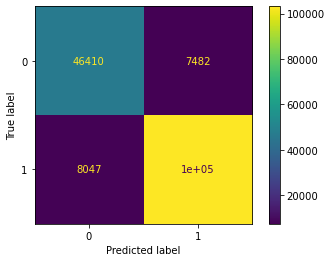

In [ ]:
plot_confusion_matrix(best_m, X_test_tfidf, y_test_tfidf)
plt.grid(False)
plt.show() 

According to the confusion matrix, we have more cases from true positive and true negative. The number of false positive and false negative cases are similar to each other.

In [ ]:
def plot_roc(true, score):
    plt.figure(figsize=(5,5))
    lw = 2
    preds = score[:,1]
    fpr, tpr, threshold = roc_curve(true, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'r', label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.grid()
    plt.show()

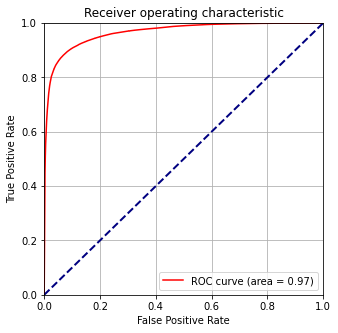

In [ ]:
pred_proba = best_m.predict_proba(X_test_tfidf)
plot_roc(y_test_tfidf, pred_proba)

The ROC curve is very close to the upper left corner with a very large AUC meaning we have a very good model predicting sentiments on test dataset.

## Prediction on Canadian Elections' Sentiment Data

In [ ]:
elections_df1 = elections_df.copy()

In [ ]:
sent_label={'positive': 1, 'negative':0}

# encode sentiment into 1 and 0
elections_df1['label'] = elections_df1['sentiment'].map(sent_label)
elections_df1 = elections_df1.drop(['sentiment'], axis=1)
elections_df1.head()

,negative_reason,text,clean_text,party,label
0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",instead suggestion agree canadian woman trust ...,Conservative,0
1,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real etobicokenorth cityofto...,Other,1
2,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next year ask jus...,Liberal,0
3,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection canadavotes elxn decide ...,Other,1
4,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayer sick tired hard earned donated...,Liberal,0


In [ ]:
X = elections_df1['clean_text']
y = elections_df1['label']

In [ ]:
# Use previously built TF-IDF, PCA on sentiment traning data to transform elections text.
X = tfidf_vect.transform(X).toarray()
X = pca2.transform(X)

In [ ]:
elec_pred = best_m.predict(X)
elec_acc = accuracy_score(y, elec_pred)
print("random forest with TF-IDF on elections - accuracy:{}".format(elec_acc))

random forest with TF-IDF on elections - accuracy:0.5939990623534928


We transform the text from elections data using the same method on sentiment training data based on previously built TD-IDF and PCA. Then we applied our best model to predict the label for tweets in elections data. The accuracy is lower, which is about 59.4%.

In [ ]:
print(classification_report(y, elec_pred))

              precision    recall  f1-score   support

           0       0.55      0.73      0.63      1006
           1       0.66      0.48      0.55      1127

    accuracy                           0.59      2133
   macro avg       0.61      0.60      0.59      2133
weighted avg       0.61      0.59      0.59      2133



Recall and f1-score on negative sentiment, and precision on positive sentiment are relatively higher.

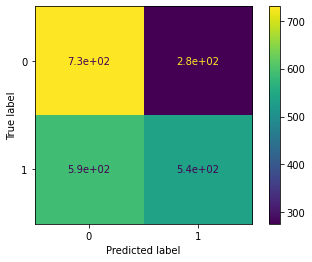

In [ ]:
plot_confusion_matrix(best_m, X, y)
plt.grid(False)
plt.show() 

Our random forest with TD-IDF is better predicting true negative sentiment elections tweet, and experiences difficulties in predicting true positive sentiment. There are quite a lot true positive tweets are predicted as negative sentiment.

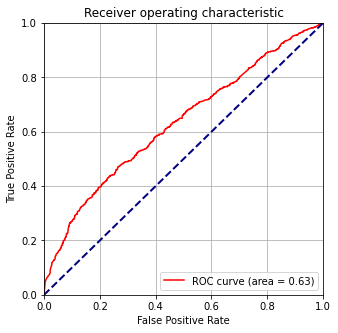

In [ ]:
pred_proba = best_m.predict_proba(X)
plot_roc(y, pred_proba)

The ROC curve is not very close to the upper left corners with AUC = 0.63.

In general, our best model built based on sentiment data does not perform well on Canadian elections data. It is fair predicting true negative cases, but it does not do a good job predicting positive cases. 

The reason behind this may be the positive words selected from the sentiment data are quite different from the true positive words in Canadian Elections data. Canadian elections data have a general theme which is all about political. Keywords in political having positive tone might not appear frequently in ordinary tweets. There are more different ways expressing positive sentiment in text that we can imagine. It is possible that political positive sentiment keywords in Canadian Election are being eliminated after applying TF-IDF and PCA built based on the training data due to occuring in lower frequency.

However, saying something bad always include those swear words that everyone knows. The keywords expressing negative sentiment in the training dataset would be more similar to the words in negative sentiment tweets from Canadian Elections data.

This explains why even with a larger data set of positive sentiment than negative sentiment in our training data, our model still experiences a difficulty to predict positive sentiment tweet in Canadian Elections data.

## Visualizing Sentiment Prediction on 3 Parties

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties/candidates. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

In [ ]:
elections_df1['sentiment_predict'] = elec_pred
elections_df1.head()

,negative_reason,text,clean_text,party,label,sentiment_predict
0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",instead suggestion agree canadian woman trust ...,Conservative,0,0
1,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real etobicokenorth cityofto...,Other,1,0
2,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next year ask jus...,Liberal,0,0
3,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection canadavotes elxn decide ...,Other,1,0
4,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayer sick tired hard earned donated...,Liberal,0,0


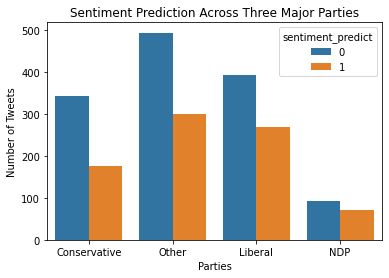

In [ ]:
ax = sns.countplot(x = "party", hue="sentiment_predict", data=elections_df1)
ax.set_title('Sentiment Prediction Across Three Major Parties')
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Parties')

class_order = ['Liberal', 'Conservative', 'NDP', 'Other'] 
hue_order = [0, 1]
bar_order = product(class_order, hue_order)

Our model predicts more negative tweets than positive tweets. Not including Other parties, Liberal party has the most positive sentiment predicted.

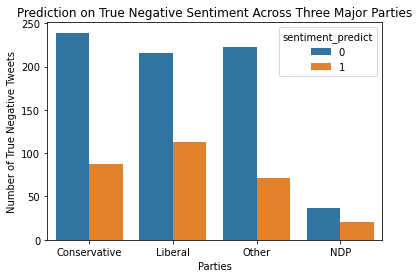

In [ ]:
neg = elections_df1[elections_df1['label'] == 0]
ax = sns.countplot(x = "party", hue="sentiment_predict", data=neg)
ax.set_title('Prediction on True Negative Sentiment Across Three Major Parties')
ax.set_ylabel('Number of True Negative Tweets')
ax.set_xlabel('Parties')

class_order = ['Liberal', 'Conservative', 'NDP', 'Other'] 
hue_order = [0, 1]
bar_order = product(class_order, hue_order)

The figure above shows the distribution of prediction on all true negative sentiment across three major parties. All the blue bars are negative predictions, which shows our model can predict true negative sentiments very well. Orange bars are lower than all blue bars meaning in most of the time, prediction is accurate across all parties. 

Text(0.5, 0, 'Parties')

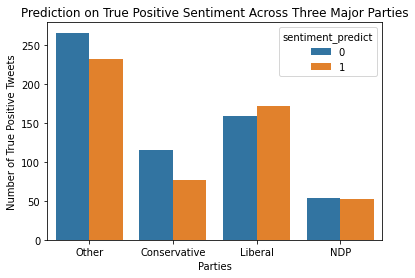

In [ ]:
pos = elections_df1[elections_df1['label'] == 1]
ax = sns.countplot(x = "party", hue="sentiment_predict", data=pos)
ax.set_title('Prediction on True Positive Sentiment Across Three Major Parties')
ax.set_ylabel('Number of True Positive Tweets')
ax.set_xlabel('Parties')

The figure above shows the distribution of prediction on all true positive sentiment across three major parties. 

As mentioned previously, due to positive sentiment keywords are hard to capture in ordinary tweets. Our model built on ordinary tweets data produce lower accuracies on predicting positive sentiment tweets. Except for Liberal party, our model predict more false negative sentiments for all the other parties.

Our model predicts more true positive sentiment tweets on Liberal party compared to all the other parties. This entails that NLP analytics based on tweets may be quite useful for knowing citizens reaction and attitude on political parties. 

Our model is not very accurate, which is only based on 20 principal components out of 1000 words TF-IDF, but it is still able to predict the true positive sentiment very well on Liberal party. This result does align with the election result; liberal party won the elections. This is because there are more positive words appeared frequently about Liberal parties on tweets compared to the other two parties. The frequency of positive words for Liberal Party is very high, which leads to more alignments with the positive words selected from training data and making more accurate predictions on Liberal Parties true positive sentiment tweets. 

## Prediction on Canadian Elections Data Negative Reason

Split the negative Canadian elections tweets into training data (70%) and test data (30%). Use the true sentiment labels in the Canadian elections data instead of your predictions from the previous part. Choose three algorithms from classification algorithms (choose any 3 from logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)), train multi-class classification models to predict the reason for the negative tweets. Tune the hyperparameters and chose the model with best score to test your prediction reason for negative sentiment tweets. There are 5 different negative reasons labelled in the dataset.

In [ ]:
elections_df1 = elections_df.copy()

In [ ]:
# model preparation
elections_df1 = elections_df1.drop(elections_df1[elections_df1.sentiment == 'positive'].index)
elections_df1 = elections_df1.drop(['text'], axis=1)
elections_df1 = elections_df1.drop(['sentiment'], axis=1)
elections_df1.head()

,negative_reason,clean_text,party
0,Women Reproductive right and Racism,instead suggestion agree canadian woman trust ...,Conservative
2,Economy,brantford going cost billion next year ask jus...,Liberal
4,Economy,canada taxpayer sick tired hard earned donated...,Liberal
5,Others,canadavotes elxn cdnpoli fact blastfromthepast...,Conservative
8,Others,chooseforward cdnpoli elxn canada make america...,Liberal


In [ ]:
elections_df1['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

In [ ]:
neg_label={'Others':1, 'Scandal':2, 'Tell lies':3, 'Economy':4, 'Women Reproductive right and Racism':5, 
            'Climate Problem':6, 'Separation':7, 'Privilege':8, 'Healthcare':9, 
            'Healthcare and Marijuana':10}

In [ ]:
# encode the 10 negative reasons into 10 labels
elections_df1['neg_label'] = elections_df1['negative_reason'].map(neg_label)
elections_df1 = elections_df1.drop(['negative_reason'], axis=1)
elections_df1.head(10)

,clean_text,party,neg_label
0,instead suggestion agree canadian woman trust ...,Conservative,5
2,brantford going cost billion next year ask jus...,Liberal,4
4,canada taxpayer sick tired hard earned donated...,Liberal,4
5,canadavotes elxn cdnpoli fact blastfromthepast...,Conservative,1
8,chooseforward cdnpoli elxn canada make america...,Liberal,1
9,cpckinsellagate let see receipt pay warren kin...,Liberal,2
14,kinsella run deep w cpc lyingandy crazed anti ...,Conservative,1
15,lyingandy history answering embarrassing quest...,Conservative,3
19,urgent please watch video david haskell people...,Conservative,2
20,policy comment illegal immoral nefarious activ...,Liberal,1


In [ ]:
elections_df2 = elections_df1.copy()
X_elec = elections_df2['clean_text']
y_elec = elections_df2['neg_label']
X_train_elec, X_test_elec, y_train_elec, y_test_elec = train_test_split(X_elec, y_elec, test_size = 0.3, random_state = 7)

In [ ]:
# Conduct a new TF-IDF to obtain 1000 features in model preparation
tfidf_vect2 = TfidfVectorizer(max_features = 1000)
X_train_elec_tfidf = tfidf_vect2.fit_transform(X_train_elec).toarray()
X_test_elec_tfidf = tfidf_vect2.transform(X_test_elec).toarray()

tfidf_traindf_elec = pd.DataFrame(X_train_elec_tfidf, columns=tfidf_vect2.get_feature_names())
tfidf_testdf_elec = pd.DataFrame(X_test_elec_tfidf, columns=tfidf_vect2.get_feature_names())
tfidf_traindf_elec.head()

,ab,abc,able,ableg,abortion,abpoli,absolute,access,account,accountable,actual,actually,ad,added,affect,afraid,agenda,ago,agree,agreement,ahead,air,alberta,allowed,allowing,alltheway,almost,along,already,also,always,american,among,andrew,andrewscheer,andy,another,answer,anti,anymore,...,wk,wolf,woman,wonder,wondering,word,work,worked,working,world,worse,worst,worth,would,wow,writ,wrong,xa,xac,xad,xb,xba,xbc,xc,xe,xef,xf,yankeedoodleandy,yeah,year,yell,yelling,yes,yesterday,yet,ygk,yql,yr,yup,yyc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.401966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train_elec_tfidf = y_train_elec
y_test_elec_tfidf = y_test_elec

#### knn

In [ ]:
params=[{'n_neighbors': [5,10,11,15,20], 'weights': ['uniform', 'distance']}]
tfidf_elec_knn = KNeighborsClassifier()
gs_tfidf_elec_knn = GridSearchCV(estimator = tfidf_elec_knn, param_grid = params, scoring = 'accuracy')
best_tfidf_elec_knn_p = gs_tfidf_elec_knn.fit(X_train_elec_tfidf, y_train_elec_tfidf)
print("Best hyperparameters:", best_tfidf_elec_knn_p.best_params_)
print("Best score:", best_tfidf_elec_knn_p.best_score_)

best_tfidf_elec_knn = gs_tfidf_elec_knn.best_estimator_
tfidf_elec_knn_pred = best_tfidf_elec_knn.predict(X_test_elec_tfidf)
tfidf_elec_knn_acc = accuracy_score(y_test_elec_tfidf, tfidf_elec_knn_pred)
print("k-NN with TF-IDF on elections test dataset - accuracy:{}".format(tfidf_elec_knn_acc))
# Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance'}
# Best score: 0.4659371833839919
# k-NN with TF-IDF on elections test dataset - accuracy:0.5033112582781457

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance'}
Best score: 0.4659371833839919
k-NN with TF-IDF on elections test dataset - accuracy:0.5033112582781457


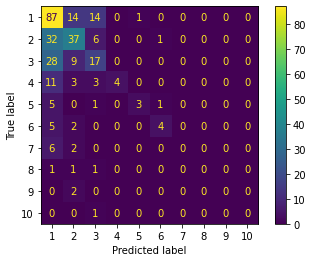

In [ ]:
plot_confusion_matrix(best_tfidf_elec_knn, X_test_elec_tfidf, y_test_elec_tfidf)
plt.grid(False)
plt.show()

By obtaining 1000 features, kNN predicts the 10 negative reasons on test set with accuracy around 50.3%. kNN predicts the first reason quite accurate because the first reason has more data than others. It falsely predicts other reasons also as the first one. The best hyperparameters combination for this model are 20 neighbours and distance as the metric for weights.

#### SVM

In [ ]:
#svc
params=[{'C': [0.01, 0.1, 1], 'class_weight': ['balanced', None], 'decision_function_shape': ['ovo'],'break_ties': [False] },
       {'C': [0.01, 0.1, 1], 'class_weight': ['balanced', None], 'decision_function_shape': ['ovr'],'break_ties': [True] }]
tfidf_elec_svm = SVC(random_state = 7)
gs_tfidf_elec_svm = GridSearchCV(estimator = tfidf_elec_svm, param_grid = params, scoring = 'accuracy')
best_tfidf_elec_svm_p = gs_tfidf_elec_svm.fit(X_train_elec_tfidf, y_train_elec_tfidf)
print("Best hyperparameters:", best_tfidf_elec_svm_p.best_params_)
print("Best score:", best_tfidf_elec_svm_p.best_score_)

best_tfidf_elec_svm = gs_tfidf_elec_svm.best_estimator_
tfidf_elec_svm_pred = best_tfidf_elec_svm.predict(X_test_elec_tfidf)
tfidf_elec_svm_acc = accuracy_score(y_test_elec_tfidf, tfidf_elec_svm_pred)
print("SVM with TF-IDF on elections test dataset - accuracy:{}".format(tfidf_elec_svm_acc))
# Best hyperparameters: {'C': 1, 'break_ties': False, 'class_weight': None, 'decision_function_shape': 'ovo'}
# Best score: 0.46592705167173254
# SVM with TF-IDF on elections test dataset - accuracy:0.4768211920529801

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best hyperparameters: {'C': 1, 'break_ties': False, 'class_weight': None, 'decision_function_shape': 'ovo'}
Best score: 0.46592705167173254
SVM with TF-IDF on elections test dataset - accuracy:0.4768211920529801


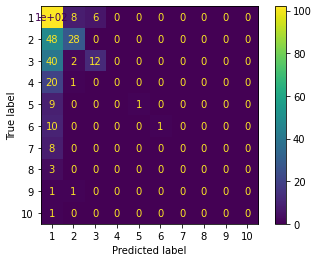

In [ ]:
plot_confusion_matrix(best_tfidf_elec_svm, X_test_elec_tfidf, y_test_elec_tfidf) 
plt.grid(False) 
plt.show()

Since this is a smaller dataset, a standard SVM is applied to predict the 10 reasons. The accuracy on test set is around 47.7%. It predicts more true cases for the first reason, but not very well for the rest of the reasons. It falsely predicts the rest of the reasons as reason 1. It might be hard to SVM to explicitlt separate the 10 reasons. The best hyperparameter for SVM is C=1, decision function shape as 'ovo'.

#### Random Forest

In [ ]:
params=[{'max_depth': [None, 50], 'n_estimators': [50,100], 
         'criterion':['gini', 'entropy'], 'max_features':['auto', 'sqrt', 'log2']}]
tfidf_elec_rf = RandomForestClassifier(random_state = 7)
gs_tfidf_elec_rf = GridSearchCV(estimator = tfidf_elec_rf, param_grid = params, scoring = 'accuracy')
best_tfidf_elec_rf_p = gs_tfidf_elec_rf.fit(X_train_elec_tfidf, y_train_elec_tfidf)
print("Best hyperparameters:", best_tfidf_elec_rf_p.best_params_)
print("Best score:",best_tfidf_elec_rf_p.best_score_)

best_tfidf_elec_rf =  gs_tfidf_elec_rf.best_estimator_
tfidf_elec_rf_pred = best_tfidf_elec_rf.predict(X_test_elec_tfidf)
tfidf_elec_rf_acc = accuracy_score(y_test_elec_tfidf, tfidf_elec_rf_pred)
print("random forest with TF-IDF on test dataset - accuracy:{}".format(tfidf_elec_rf_acc))
# obtain new features
# Best hyperparameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 100}
# Best score: 0.5781560283687944
# random forest with TF-IDF on test dataset - accuracy:0.5596026490066225

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best hyperparameters: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 100}
Best score: 0.5781560283687944
random forest with TF-IDF on test dataset - accuracy:0.5596026490066225


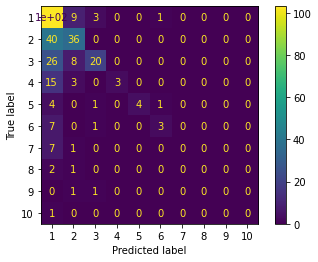

In [ ]:
plot_confusion_matrix(best_tfidf_elec_rf, X_test_elec_tfidf, y_test_elec_tfidf)
plt.grid(False)   
plt.show() 

Compared to the previous two algorithms, random forest again outperforms. It did very good job on predicting reason 1, 2 and 3. The reason why it outperforms maybe decision tree is better at addressing the target labels in leaves when there are multiple labels for prediction. The best hyperparameter combination is gini, maximum depth as 50, no limits on maximum features and 100 estimators.

## Results Discussion

Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. For both models, suggest one way you can improve the accuracy of your models.

Our research question asks "What can public opinion on Twitter tell us about the Canadian political landscape in 2019?". Based on our first model built on twitter data and predict sentiment in Canadian Elections data, we can see that our model is better at predicting negative sentiment than the positive sentiment tweets in Canadian Elections data. This shows that the negative public opinions consists of very common negative words that frequently appears in ordinary Twitter. Swear words are commonly used in all different topic themes including political opinions. However, it is harder to predict positive sentiment tweet in Canadian Elections data, since the the positive words selected from the sentiment data may be quite different from the true positive words in Canadian elections data. Canadian elections data have a general theme which is all about political. Keywords in political having positive tone might not appear frequently in ordinary tweets. There are more different ways to express positive sentiment in text that we can imagine for political topics compared to ordinary text. Thus, political positive sentiment keywords in Canadian Elections data are highly probable being eliminated after applying TF-IDF and PCA built on training data due to occurring in lower frequency.

However, when we categorize the prediction based on political parties and examine data separately on true positive and true negative sentiments on Canadian election data, we are able to see NLP analysis on political opinions are quite powerful. Our model did a very good job predicting true negative sentiment tweets in Canadian Elections data. Approximately less than one-third of the true negative sentiment are predicted as positive. 

More interestingly, the prediction on true positive sentiment for Canadian Elections data can reveal the actual result from 2019 elections. Our model is able to predict more accurately on Liberal Party's true positive sentiment compared to all other parties. This is mostly because there are more positive words appeared frequently about Liberal party on tweets compared to the other two parties. The frequency of positive words for Liberal Party is very high, and common to the positive words selected from training data. 

From the two figures about predictions on true positive and true negative sentiment across three parties, we are able to see Conservative Party have more negative sentiment predictions regardless correctness. In the true sentiment labels on three parties in exploratory analysis, Conservative Party is also the only one party that has more negative tweets than positive tweets. Both the prediction and true labels show the negative public opinions on Conservative party. In the negative reasons decompositions, Conservative party has more explicitly negative reasons rather than "Other reason", it has more scandal as negative reasons than others, which may reflect the true attitude from public.

NDP have more true positive sentiments then negative sentiments. In predicting the sentiment, positive and negative sentiments are very similar. In overall, the data labelled in NDP is very small. This might be due to inaccurate labelling, but also the sample from true NDP tweets may be also small. This also entail the truth that the vote for NDP is less compared to Liberal and Conservative.

The accuracies are lower in models predicting negative reasons. Several reasons are listed below:
1. The major reason is the target label becomes multiclass rather than binary class. There are 10 different labels need to be predicted, which adds to the difficulty. 
2. The amount of negative reason data is very small. There are only 1000 samples. It limits the algorithm's ability to better train and learn from the small amount of data.
3. The number of negative reasons categories is unbalanced. Most of the negative reasons belong to Others (364 samples), Scandal (270 samples) and Tell Lies (198). There are only a few cases belong to other group. Healthcare and Marijuana as negative reason only has 4 samples. If some negative reasons are grouped into one, the accuracy will rise; however, the prediction on specific reasons cannot be revealed anymore. Since healthcare opinion specifically related to Marijuana is important to be examined as one stand alone reason, since government might want to know the social and health effect after making marijuana legal.
4. Small and imbalanced dataset leads to the insufficient amount of data in test sets. As you can see there are warnings under each model output that the least populated y has only 3 data. This cannot reveal whether the model is accurate or not due to very small dataset.

For both models, we need more data and more balanced data. For the first model, we have extremely more positive sentiment data than negative data. For the second model, we need more data for the group with only 4 or 5 data points to evaluate and improve our model.

Including more various hyperparameters in grid search will help us find better model with higher accuracies.

For bonus, self-trained word embeddings are used with neural network to make predictions. Pre-trained embeddings can be used to have higher accuracies.

## Bonus word embeddings with artificial neural network

#### Build model on training data set

In [ ]:
# Reference: https://www.kaggle.com/bertcarremans/deep-learning-for-sentiment-analysis
# Refernece: https://www.freecodecamp.org/news/handling-overfitting-in-deep-learning-models/

In [ ]:
sentiment_df_we = sentiment_df.copy()
sentiment_df_we.head()

,ID,text,label,clean_text
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,josh jenkins looking forward tab breeder crown...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,congratulation pakistan becoming testteam worl...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,september taking maine mendoza surprise thanks...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,newly painted wall thanks million custodial pa...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,excited announce july feschotte lab relocating...


In [ ]:
# We will use neural network algorithms from keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras import regularizers
import collections

In [ ]:
# make paramters ready for our self-trained word embeddings
NB_WORDS = 10000  # Select 10000 words and put into the dictionary for self-trained word embeddings
VAL_SIZE = 1000  # Size of the validation data set
NB_START_EPOCHS = 25  # Number of epochs to train neural network
BATCH_SIZE = 512  # the number of samples that will be propagated through our neural network
MAX_LEN = 23  # maximum number of words in a sequence

In [ ]:
X_we = sentiment_df_we.clean_text
y_we = sentiment_df_we.label
X_train_we, X_test_we, y_train_we, y_test_we = train_test_split(X_we, y_we, test_size= .3, random_state = 7)

In [ ]:
# preprocess our text, initiate the tokenizer
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
# fit our train data into the tokenizer
tk.fit_on_texts(X_train_we)

# Convert words into integers in sequences
X_train_seq = tk.texts_to_sequences(X_train_we)
X_test_seq = tk.texts_to_sequences(X_test_we)

In [ ]:
# we check the summary of the sequences, we are able to see the maximum sequence length is 23, so we set max_length as 23.
seq_lengths = X_train_we.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    385273.000000
mean          6.816232
std           3.019261
min           1.000000
25%           4.000000
50%           7.000000
75%           9.000000
max          23.000000
Name: clean_text, dtype: float64

In [ ]:
# Control each sequence with same length
MAX_LEN = 23
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [ ]:
# Encoding our binary label into array/bectors with 2 columns
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_we)
y_test_le = le.transform(y_test_we)
y_train_oh = to_categorical(y_train_le, 2)
y_test_oh = to_categorical(y_test_le, 2)

In [ ]:
# split the training data into training and validation set
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state = 7)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (38528, 23)


In [ ]:
# build our neural networks
emb_model = models.Sequential() 

# special embedding layer with input dimension as 10000 sequences, output dimension as 8, input length as 23
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN)) 

emb_model.add(layers.Flatten()) # into one sequence
emb_model.add(layers.Dense(2, activation='softmax')) # only 2 neurons in that layer, since we only have two classes for prediction
emb_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 23, 8)             80000     
_________________________________________________________________
flatten_10 (Flatten)         (None, 184)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 370       
Total params: 80,370
Trainable params: 80,370
Non-trainable params: 0
_________________________________________________________________


The special embedding layer at the very beginning computes our self-trained embeddings and looks up each word in the dictionary to find its vector representation. 

We need to take the output from the embedding layer and bring it into a hidden dense layer. Before plugging into the hidden layer, we need to add a flatten layer in between in order to prepare the sequential input for the hidden dense layer.

Since we have binary output, we put the last layer as having 2 neurons, with activation softmax for classification problems.

In [ ]:
from keras import callbacks
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set at very beginning
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)
    
    history = model.fit(X_train, y_train, epochs=NB_START_EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_valid, y_valid), 
                        verbose=1, callbacks=[es_callback])
    
    return history

We use the deep model function to compile the model using rmsprop optimizer, categorical_corssentropy for loss, and use accuracy as the metrics to evaluate the model. An early stop callback is set here with patience=3 to avoid overfitting when there are many epochs. The network will stop train after 3 epoch when the loss rises.

In [ ]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/25
678/678 [==============================] - 2s 2ms/step - loss: 0.4431 - accuracy: 0.7881 - val_loss: 0.1110 - val_accuracy: 0.9628
Epoch 2/25
678/678 [==============================] - 2s 2ms/step - loss: 0.1015 - accuracy: 0.9650 - val_loss: 0.0914 - val_accuracy: 0.9675
Epoch 3/25
678/678 [==============================] - 1s 2ms/step - loss: 0.0852 - accuracy: 0.9706 - val_loss: 0.0878 - val_accuracy: 0.9698
Epoch 4/25
678/678 [==============================] - 1s 2ms/step - loss: 0.0791 - accuracy: 0.9722 - val_loss: 0.0857 - val_accuracy: 0.9703
Epoch 5/25
678/678 [==============================] - 1s 2ms/step - loss: 0.0783 - accuracy: 0.9729 - val_loss: 0.0854 - val_accuracy: 0.9706
Epoch 6/25
678/678 [==============================] - 1s 2ms/step - loss: 0.0755 - accuracy: 0.9738 - val_loss: 0.0857 - val_accuracy: 0.9705
Epoch 7/25
678/678 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.9745 - val_loss: 0.0846 - val_accuracy: 0.9706
Epoch 

In [ ]:
def eval_metric(history, metric_name):
    '''
    Visualize a trained model on training and validation data 
    with a chosen metric in a line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    plt.plot(metric, 'bo', label='Train ' + metric_name)
    plt.plot(val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

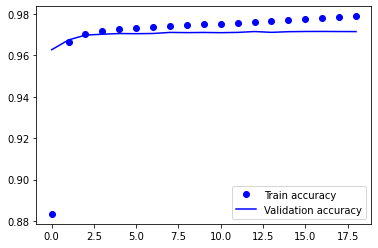

In [ ]:
eval_metric(emb_history, 'accuracy')

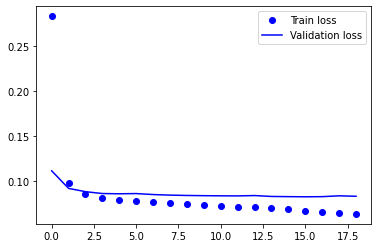

In [ ]:
eval_metric(emb_history, 'loss')

We can see from the fifth epoch, the trained model starts to overfit the training data from both loss and accuracy metrics.

In [ ]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Apply the trained model on test data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train, y_train, epochs=epoch_stop, batch_size=BATCH_SIZE, verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [ ]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

5160/5160 [==============================] - 5s 917us/step - loss: 0.0868 - accuracy: 0.9699
/n
Test accuracy of word embeddings model: 96.99%


The accuracy is very high on predicting test dataset with 96.99%

#### Predictions on Canadian Elections Sentiment Data

In [ ]:
elections_df_we = elections_df.copy()

# encode into 0 and 1.
sent_label={'positive': 1, 'negative':0}
elections_df_we['label'] = elections_df_we['sentiment'].map(sent_label)

X_elec = elections_df_we['clean_text']
y_elec = elections_df_we['label']

In [ ]:
# Transform text into integers in sequence and control it with the 
# same maximum length using same method from previous section
X_elec_s = tk.texts_to_sequences(X_elec)
X_elec_s_trunc = pad_sequences(X_elec_s, maxlen=23)

In [ ]:
# Apply trained model to Canadian Elections text
elec_pred = emb_model.predict_classes(X_elec_s_trunc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
accuracy_score(y_elec, elec_pred)

0.647444913267698

The best model we built prreviously is the random forest with TF-IDF. The accuracy that model reaches on Canadian Elections sentiment data is 59.4%. This neural network with word embeddings can reach slightly higher with accuracy equals to 64.7%. Higher accuracies are due to more complex learning in work embeddings, and word embeddings consider various relationships between the words in a sequence rather than simple frequency calculations

#### Predictions on Canadian Electons Negative Reasons Data

In [ ]:
elections_nr_we = elections_df.copy()

# model preparation
elections_nr_we = elections_nr_we.drop(elections_nr_we[elections_nr_we.sentiment == 'positive'].index)
elections_nr_we = elections_nr_we.drop(['text'], axis=1)
elections_nr_we = elections_nr_we.drop(['sentiment'], axis=1)

In [ ]:
neg_label={'Others':1, 'Scandal':2, 'Tell lies':3, 'Economy':4, 'Women Reproductive right and Racism':5, 
            'Climate Problem':6, 'Separation':7, 'Privilege':8, 'Healthcare':9, 
            'Healthcare and Marijuana':10}
elections_nr_we['neg_label'] = elections_nr_we['negative_reason'].map(neg_label)
elections_nr_we = elections_nr_we.drop(['negative_reason'], axis=1)

In [ ]:
# make paramters ready for our self-trained word embeddings
NB_WORDS = 10000  # Select 10000 words and put into the dictionary for self-trained word embeddings
VAL_SIZE = 1000  # Size of the validation data set
NB_START_EPOCHS = 25  # Number of epochs to train neural network
BATCH_SIZE = 512  # the number of samples that will be propagated through our neural network
MAX_LEN = 23  # maximum number of words in a sequence

In [ ]:
X_we = elections_nr_we.clean_text
y_we = elections_nr_we.neg_label
X_train_we, X_test_we, y_train_we, y_test_we = train_test_split(X_we, y_we, test_size= .3, random_state = 7)

In [ ]:
# preprocess our text, initiate the tokenizer
tk2 = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
# fit our train data into the tokenizer
tk2.fit_on_texts(X_train_we)

# Convert words into integers in sequences
X_train_seq = tk2.texts_to_sequences(X_train_we)
X_test_seq = tk2.texts_to_sequences(X_test_we)

In [ ]:
seq_lengths = X_train_we.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    704.000000
mean      18.933239
std        9.519155
min        2.000000
25%       12.000000
50%       18.000000
75%       24.000000
max      101.000000
Name: clean_text, dtype: float64

In [ ]:
# Control each sequence with same length
MAX_LEN = 101
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [ ]:
# Encoding our binary label into array/bectors with 11 columns, since our label starts with 1
y_train_oh = to_categorical(y_train_we.values, 11)
y_test_oh = to_categorical(y_test_we.values, 11)

In [ ]:
# split the training data into training and validation set
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state = 7)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (71, 101)


In [ ]:
# build our neural networks
emb_model = models.Sequential() 

# special embedding layer with input dimension as 10000 sequences, output dimension as 8, input length as 23
emb_model.add(layers.Embedding(NB_WORDS, 10, input_length=MAX_LEN)) 
emb_model.add(layers.Conv1D(128, 5, activation='relu'))
emb_model.add(layers.GlobalMaxPool1D())
# emb_model.add(layers.Flatten()) # into one sequence
emb_model.add(layers.Dense(11, activation='softmax')) # only 11 neurons in that layer
emb_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 101, 10)           100000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 97, 128)           6528      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 11)                1419      
Total params: 107,947
Trainable params: 107,947
Non-trainable params: 0
_________________________________________________________________


The Conv1D layer assumes a 1 dimension array that makes a multiplication with the elements.It helps in maximizing or minimizing the intensity of values and while reducing the dimension to achieve better predictions.

The global max pooling computes a single max value for each of the input channels, which can be used as an alternative to the flatten layer after the last pooling block of the convolutional neural network.




In [ ]:
# change epoch to 30
emb_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)
    
history = emb_model.fit(X_train_emb, y_train_emb, epochs=30, batch_size=BATCH_SIZE, 
                        validation_data=(X_valid_emb, y_valid_emb), 
                        verbose=1, callbacks=[es_callback])

Epoch 1/30
2/2 [==============================] - 1s 216ms/step - loss: 2.4138 - accuracy: 0.0483 - val_loss: 2.3557 - val_accuracy: 0.3944
Epoch 2/30
2/2 [==============================] - 0s 54ms/step - loss: 2.3496 - accuracy: 0.3581 - val_loss: 2.3144 - val_accuracy: 0.3944
Epoch 3/30
2/2 [==============================] - 0s 57ms/step - loss: 2.3060 - accuracy: 0.3522 - val_loss: 2.2752 - val_accuracy: 0.3944
Epoch 4/30
2/2 [==============================] - 0s 54ms/step - loss: 2.2650 - accuracy: 0.3469 - val_loss: 2.2367 - val_accuracy: 0.3944
Epoch 5/30
2/2 [==============================] - 0s 55ms/step - loss: 2.2257 - accuracy: 0.3482 - val_loss: 2.1966 - val_accuracy: 0.3944
Epoch 6/30
2/2 [==============================] - 0s 53ms/step - loss: 2.1844 - accuracy: 0.3476 - val_loss: 2.1543 - val_accuracy: 0.3944
Epoch 7/30
2/2 [==============================] - 0s 53ms/step - loss: 2.1391 - accuracy: 0.3495 - val_loss: 2.1142 - val_accuracy: 0.3944
Epoch 8/30
2/2 [==========

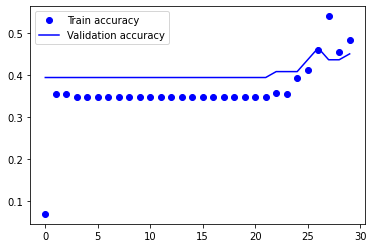

In [ ]:
eval_metric(history, 'accuracy')

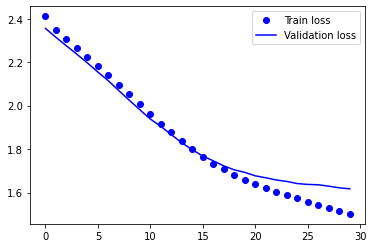

In [ ]:
eval_metric(history, 'loss')

Neural network overfits to the train data after around 20 epochs.

In [ ]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 11)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

10/10 [==============================] - 0s 2ms/step - loss: 1.5963 - accuracy: 0.4404
/n
Test accuracy of word embeddings model: 44.04%


The accuracy is similar to what Random Forest with TF-IDF have reached. With a smaller dataset, even neural network cannot really learn well because the data does not provide a good representation of what the negative reasons truly look like in tweets.